In [1]:
import yfinance as yf
import sklearn
import pandas as pd
import datetime
from finta import TA
import time
import numpy as np

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

In [2]:
NUM_DAYS = 1000     # The number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data

In [3]:
INDICATORS = ['RSI', 'MACD',
              'STOCH', 'ADL',
              'ATR', 'MOM',
              'MFI', 'ROC',
              'OBV', 'CCI',
              'EMV', 'VORTEX']

tickers = ('TSLA', 'GOOGL', 'GME', 'AMZN')

In [4]:
def _get_historical_data(tickers, NUM_DAYS, INTERVAL):
    """
    Function that uses the yfinance API to get stock data
    :return:
    """

    start = (datetime.date.today() - datetime.timedelta(NUM_DAYS))
    end = datetime.datetime.today()

#     data = yf.download(ticker, start=start, end=end, interval=INTERVAL)
    data = yf.download(tickers, start=start, end=end, interval=INTERVAL, group_by='Ticker')
    data = data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)
    data.rename(columns={"Close": 'close',
                         "Adj Close": 'adj close',
                         "High": 'high',
                         "Low": 'low',
                         'Volume': 'volume',
                         'Open': 'open'},
                inplace=True)
    return data


[*********************100%***********************]  4 of 4 completed


Ticker
AMZN     AxesSubplot(0.125,0.2;0.775x0.68)
GME      AxesSubplot(0.125,0.2;0.775x0.68)
GOOGL    AxesSubplot(0.125,0.2;0.775x0.68)
TSLA     AxesSubplot(0.125,0.2;0.775x0.68)
Name: adj close, dtype: object

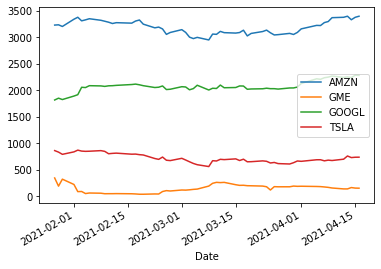

In [5]:
stock_df = _get_historical_data(tickers, NUM_DAYS = 1000, INTERVAL= '1d')
stock_df.last('80D').groupby('Ticker')['adj close'].plot(legend=True)

In [6]:
def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    return data.ewm(alpha=alpha).mean()


def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['adj close'])

    return data

def clean_data(df, alpha=0.65):
    """
    Combine all data manipulation functions

    :param df: dataframe
    :param alpha: exponent factor
    :param window: look ahead time in days
    :return:
    Dataframe with features and prediction target
    """
    df = _exponential_smooth(df, alpha=alpha)
    df = _get_indicator_data(df)
#     df.dropna(inplace=True)

    return df

def _produce_prediction(data, window=7):
    """
    Function that produces the 'truth' values
    At a given row, it looks 'window' rows ahead to see if the price increased (1) or decreased (0)
    :param window: number of days, or rows to look ahead to see what the price did
    """

    prediction = (data.close.shift(-window) >= data.close)
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    data.dropna(inplace=True)

    return data

In [7]:
df_list = []
for ticker in tickers:
    df_list.append(
        _produce_prediction(
            (clean_data(stock_df.loc[stock_df.Ticker == ticker]))
        )
    )
    
ml_df = pd.concat(df_list).sort_index(kind='merge')

In [8]:
print(ml_df.tail())
print(ml_df.shape)

                  close  14 period RSI       MACD     SIGNAL  \
Date                                                           
2021-04-06  3213.407438      63.279041   2.882352 -16.773289   
2021-04-07   676.759510      50.208723 -11.842769 -19.902359   
2021-04-07  2224.868650      78.719850  36.775096  19.509314   
2021-04-07   180.721553      52.887617  11.556881  16.842734   
2021-04-07  3256.296034      67.200276  13.529100 -10.712811   

            14 period STOCH %K           MFV  14 period ATR         MOM  \
Date                                                                      
2021-04-06           91.420954  1.001037e+08      65.864156  116.937055   
2021-04-07           79.157486  2.943210e+09      32.780757   13.137114   
2021-04-07           96.033554  5.880667e+07      44.043100  187.088888   
2021-04-07           54.994797 -4.314619e+08      30.473012   -6.420008   
2021-04-07           91.518485  1.011612e+08      64.548470  133.156400   

            14 period MFI

In [9]:
X = ml_df.drop('pred', axis = 1)
y = ml_df.pred

In [16]:
clf = RandomForestClassifier(n_estimators=90)
clf.fit(X,y)

RandomForestClassifier(n_estimators=90)

In [17]:
print(np.mean(cross_val_score(clf, X, y, cv=8)))

0.4375


# Generate prediction

<AxesSubplot:xlabel='Date'>

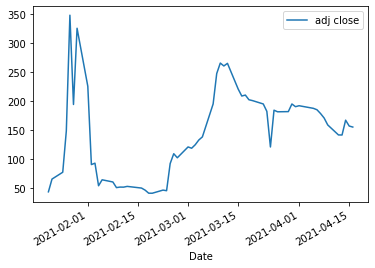

In [18]:
goog_df = stock_df.loc[stock_df.Ticker == 'GME']
goog_df[['adj close']][-60:].plot()

In [19]:
goog_ml_df = _produce_prediction(
    (clean_data(goog_df))
)

X_goog = goog_ml_df.iloc[:, :-1]
y_goog = goog_ml_df.pred

In [20]:
buy_sell = {1: 'Stock going up, buy',
            0: 'Stock going down, sell'}

"This is the prediction for next 7 days:"
pred_df = (clean_data(goog_df))

print(buy_sell[clf.predict(pred_df[-1:])[0]])

Stock going up, buy


In [21]:
clf.predict_proba(pred_df[-1:])[0][1]

0.6333333333333333

In [22]:
print(np.mean(cross_val_score(clf, X_goog, y_goog, cv=8)))

0.4682300631095812


In [24]:
clf.

'gini'

In [ ]:
# from sklearn import tree
# import matplotlib.pyplot as plt

# fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,20), dpi=800)
# tree.plot_tree(clf.estimators_[0],
#                feature_names = X.columns, 
#                class_names=y.name,
#                filled = True)

In [ ]:
# fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (50,10), dpi=900)
# for index in range(0, 5):
#     tree.plot_tree(clf.estimators_[index],
#                    feature_names = X.columns, 
#                    class_names=y.name,
#                    filled = True,
#                    ax = axes[index]);

#     axes[index].set_title('Estimator: ' + str(index), fontsize = 11)

In [ ]:
len(clf.estimators_)

In [ ]:
def _get_historical_data_mt(tickers, NUM_DAYS, INTERVAL):
    """
    Function that uses the yfinance API to get stock data
    :return:
    """

    start = (datetime.date.today() - datetime.timedelta(NUM_DAYS))
    end = datetime.datetime.today()

    data = yf.download(tickers, start=start, end=end, interval=INTERVAL, group_by='Ticker')
    data = data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)
    data.rename(columns={"Ticker":"ticker",
                         "Close": 'close',
                         "Adj Close": 'adj close',
                         "High": 'high',
                         "Low": 'low',
                         'Volume': 'volume',
                         'Open': 'open'},
                inplace=True)
    return data

def _produce_prediction_mt(data, window=7):
    """
    Function that produces the 'truth' values
    At a given row, it looks 'window' rows ahead to see if the price increased (1) or decreased (0)
    :param window: number of days, or rows to look ahead to see what the price did
    """
    
    data['pred'] = (data.groupby('ticker').close.shift(-window) >= data.close)
    for t in data.ticker.unique():
      data.loc[data.ticker == t, 'pred'] = data.loc[df.ticker == t, 'pred'].iloc[:-window]
    data.dropna(inplace=True)
    data['pred'] = data['pred'].astype(int)

    return data

Date Ticker    adj close        close         high          low  \
0    2018-07-23   AMZN  1802.000000  1802.000000  1819.000000  1769.989990   
1    2018-07-23    GME    13.684457    14.890000    15.090000    14.780000   
2    2018-07-23  GOOGL  1211.000000  1211.000000  1215.099976  1192.010010   
3    2018-07-23   TSLA    60.639999    60.639999    61.099998    58.571999   
4    2018-07-24   AMZN  1829.239990  1829.239990  1840.000000  1809.380005   
...         ...    ...          ...          ...          ...          ...   
2751 2021-04-15   TSLA   738.849976   738.849976   743.690002   721.309998   
2752 2021-04-16   AMZN  3399.439941  3399.439941  3406.800049  3355.590088   
2753 2021-04-16    GME   154.690002   154.690002   160.199997   151.250000   
2754 2021-04-16  GOOGL  2282.750000  2282.750000  2294.239990  2270.919922   
2755 2021-04-16   TSLA   739.780029   739.780029   749.409973   724.599976   

             open    volume  
0     1812.209961   3888500  
1       15.050000   1833800  
2     1195.660034   3272300  
3       60.368000  54964500  
4     1829.010010   4278700  
...           ...       ...  
2751   743.099976  27848900  
2752  3380.000000   3183300  
2753   156.000000   5139700  
2754  2289.239990   1313600  
2755   728.650024  27924000  

[2756 rows x 8 columns]

In [25]:
import altair as alt

In [ ]:
# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['date'], empty='none')

# The basic line
line = alt.Chart().mark_line(interpolate='basis').encode(
    alt.X('Date:T', axis=alt.Axis(title='')),
    alt.Y('close:Q', axis=alt.Axis(title='',format='$f')),
    color='symbol:N'
)

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart().mark_point().encode(
    x='Date:T',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'price:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart().mark_rule(color='gray').encode(
    x='date:T',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
stockChart = alt.layer(line, selectors, points, rules, text,
                       data='https://raw.githubusercontent.com/altair-viz/vega_datasets/master/vega_datasets/_data/stocks.csv', 
                       width=600, height=300,title='Stock History')